In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from pyasn import pyasn
from loguru import logger

from plot import ecdf
from geogiant.common.files_utils import load_json, load_pickle, load_csv
from geogiant.common.ip_addresses_utils import get_prefix_from_ip, route_view_bgp_prefix

from geogiant.common.settings import PathSettings

path_settings = PathSettings()


@dataclass(frozen=True)
class ResultsScore:
    client_granularity: str
    answer_granularity: str
    scores: list
    inconsistent_mappings: list


asndb = pyasn(str(path_settings.RIB_TABLE))
targets = load_json(path_settings.OLD_TARGETS)
vps = load_json(path_settings.OLD_VPS)

ref_error_target = load_pickle(
    path_settings.RESULTS_PATH / "ref_target_geoloc_error.pickle"
)
ref_latency_target = load_pickle(
    path_settings.RESULTS_PATH / "ref_target_min_latencies.pickle"
)

# Distance evaluation

In [2]:
extend_vp_mapping = False
filtered_hostname = True
base_input_file = f"results_{'extended_mapping' if extend_vp_mapping else 'not_extended'}_{'filtered_hostname' if filtered_hostname else 'no_filtered'}"

subnet_eval = load_pickle(
    path_settings.RESULTS_PATH / (base_input_file + "_subnet.pickle")
)
bgp_eval = load_pickle(path_settings.RESULTS_PATH / (base_input_file + "_bgp.pickle"))

2024-03-20 16:52:13.116 | INFO     | __main__:<module>:9 - Reference, geolocated ip addr = 768, median error = 5.85 [km]
2024-03-20 16:52:13.119 | INFO     | __main__:<module>:22 - probing budget = 1, geolocated ip addr = 549, median error = 123.91 [km]


2024-03-20 16:52:13.122 | INFO     | __main__:<module>:22 - probing budget = 10, geolocated ip addr = 710, median error = 26.89 [km]
2024-03-20 16:52:13.124 | INFO     | __main__:<module>:22 - probing budget = 50, geolocated ip addr = 728, median error = 12.5 [km]
2024-03-20 16:52:13.127 | INFO     | __main__:<module>:22 - probing budget = 100, geolocated ip addr = 741, median error = 10.3 [km]
2024-03-20 16:52:13.129 | INFO     | __main__:<module>:22 - probing budget = 200, geolocated ip addr = 758, median error = 8.1 [km]
2024-03-20 16:52:13.132 | INFO     | __main__:<module>:22 - probing budget = 500, geolocated ip addr = 759, median error = 6.47 [km]


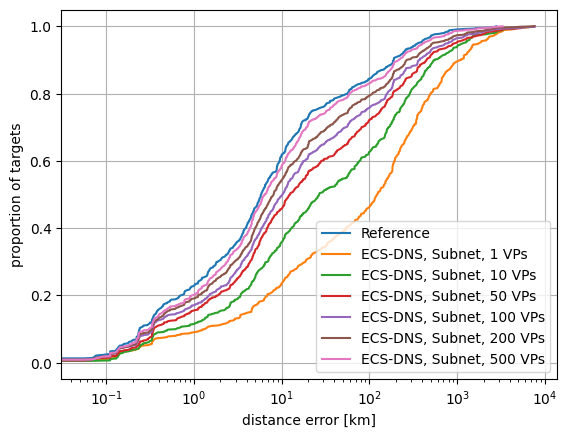

In [3]:
fig, ax1 = plt.subplots(1, 1)

# # plot results for reference vp selection
x, y = ecdf([e for e in ref_error_target.values()])
ax1.plot(x, y, label="Reference")

mean_error = np.median([l for l in ref_error_target.values()])

logger.info(
    f"Reference, geolocated ip addr = {len(ref_error_target.values())}, median error = {round(mean_error, 2)} [km]"
)

for budget, results in subnet_eval["results"].items():
    # # plot results for reference vp selection

    if budget in [1, 10, 50, 100, 200, 500]:

        x, y = ecdf([e["elected_d_error"] for e in results.values()])
        ax1.plot(x, y, label=f"ECS-DNS, Subnet, {budget} VPs")
        mean_error = np.median([l["elected_d_error"] for l in results.values()])

        logger.info(
            f"probing budget = {budget}, geolocated ip addr = {len(results.values())}, median error = {round(mean_error, 2)} [km]"
        )

plt.xlabel("distance error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="lower right", fontsize=10)
plt.xscale("log")
plt.grid()
plt.savefig(path_settings.FIGURE_PATH / "geolocation_error_ecs_dns_subnets.pdf")
plt.show()

# Min RTT evaluation

2024-03-20 16:52:14.091 | INFO     | __main__:<module>:11 - Percentage of IP addresses under 2 [ms], Reference, 60.0 [%]
2024-03-20 16:52:14.094 | INFO     | __main__:<module>:23 - budget = 1, median latency = 9.57 [ms]
2024-03-20 16:52:14.095 | INFO     | __main__:<module>:31 - Percentage of IP addresses under 2 [ms], budget=1, 12.39 [%]
2024-03-20 16:52:14.098 | INFO     | __main__:<module>:23 - budget = 10, median latency = 3.05 [ms]
2024-03-20 16:52:14.099 | INFO     | __main__:<module>:31 - Percentage of IP addresses under 2 [ms], budget=10, 22.39 [%]
2024-03-20 16:52:14.102 | INFO     | __main__:<module>:23 - budget = 50, median latency = 1.38 [ms]
2024-03-20 16:52:14.103 | INFO     | __main__:<module>:31 - Percentage of IP addresses under 2 [ms], budget=50, 36.68 [%]
2024-03-20 16:52:14.105 | INFO     | __main__:<module>:23 - budget = 100, median latency = 1.21 [ms]
2024-03-20 16:52:14.107 | INFO     | __main__:<module>:31 - Percentage of IP addresses under 2 [ms], budget=100, 4

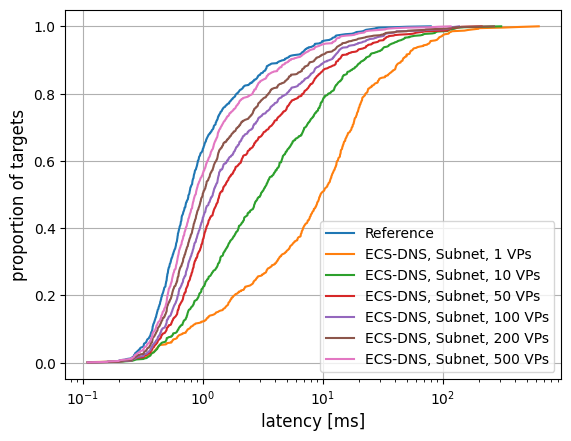

In [4]:
fig, ax1 = plt.subplots(1, 1)

# # plot results for reference vp selection
x, y = ecdf([e for e in ref_latency_target.values()])
ax1.plot(x, y, label="Reference")


for i, val in enumerate(x):
    if val > 1:
        proportion = y[i]
        logger.info(
            f"Percentage of IP addresses under 2 [ms], Reference, {round(proportion, 1) * 100} [%]"
        )
        break

# # plot results for reference vp selection
for budget, target_results in subnet_eval["results"].items():
    if budget in [1, 10, 50, 100, 200, 500]:
        x, y = ecdf([l["elected_rtt"] for l in target_results.values()])
        median_latency = np.median([l["elected_rtt"] for l in target_results.values()])

        ax1.plot(x, y, label=f"ECS-DNS, Subnet, {budget} VPs")
        logger.info(
            f"budget = {budget}, median latency = {round(median_latency, 2)} [ms]"
        )

        # get percentage of IP address with geoloc under 2 ms
        for i, val in enumerate(x):
            if val > 1:
                proportion = y[i]
                logger.info(
                    f"Percentage of IP addresses under 2 [ms], {budget=}, {round(proportion * 100, 2)} [%]"
                )
                break


plt.xlabel("latency [ms]", fontsize=12)
plt.ylabel("proportion of targets", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.xscale("log")
plt.grid()
plt.savefig(path_settings.FIGURE_PATH / "latency_ecs_dns.pdf")
plt.show()

# Latency diff to reference

2024-03-20 16:52:14.643 | INFO     | __main__:<module>:20 - budget = 1, median dif = 8.46 [ms]
2024-03-20 16:52:14.646 | INFO     | __main__:<module>:20 - budget = 10, median dif = 1.62 [ms]
2024-03-20 16:52:14.650 | INFO     | __main__:<module>:20 - budget = 50, median dif = 0.33 [ms]
2024-03-20 16:52:14.653 | INFO     | __main__:<module>:20 - budget = 100, median dif = 0.14 [ms]
2024-03-20 16:52:14.656 | INFO     | __main__:<module>:20 - budget = 200, median dif = 0.0 [ms]
2024-03-20 16:52:14.659 | INFO     | __main__:<module>:20 - budget = 500, median dif = 0.0 [ms]


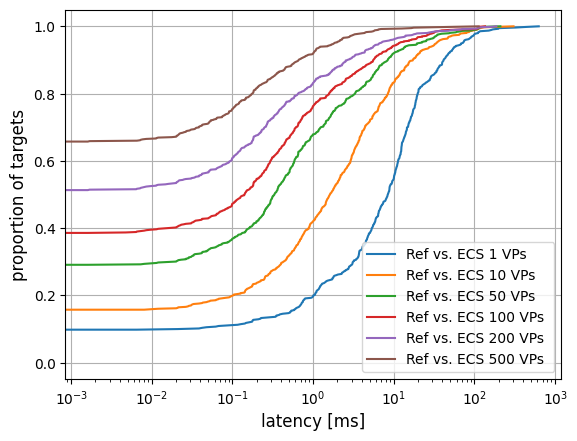

In [5]:
fig, ax1 = plt.subplots(1, 1)

# # plot results for reference vp selection
x, y = ecdf([e for e in ref_latency_target.values()])

# # plot results for reference vp selection
for budget, target_results in subnet_eval["results"].items():
    if budget in [1, 10, 50, 100, 200, 500]:
        latency_diff = {}
        for target, result in target_results.items():
            ecs_latency = result["elected_rtt"]
            ref_latency = ref_latency_target[target]

            latency_diff[target] = ecs_latency - ref_latency

        x, y = ecdf([diff for diff in latency_diff.values()])
        median_diff = np.median([diff for diff in latency_diff.values()])

        ax1.plot(x, y, label=f"Ref vs. ECS {budget} VPs ")
        logger.info(f"budget = {budget}, median dif = {round(median_diff, 2)} [ms]")

plt.xlabel("latency [ms]", fontsize=12)
plt.ylabel("proportion of targets", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.xscale("log")
plt.grid()
plt.savefig(path_settings.FIGURE_PATH / "latency_ecs_dns.pdf")
plt.show()

# Per CDN analysis

2024-03-20 16:52:16.724 | INFO     | __main__:<module>:18 - AMAZON-02, probing budget = 50, geolocated ip addr = 714, median error = 31.9 [km]
2024-03-20 16:52:16.726 | INFO     | __main__:<module>:18 - GOOGLE, probing budget = 50, geolocated ip addr = 719, median error = 58.93 [km]
2024-03-20 16:52:16.729 | INFO     | __main__:<module>:18 - CDN77, probing budget = 50, geolocated ip addr = 734, median error = 11.31 [km]
2024-03-20 16:52:16.731 | INFO     | __main__:<module>:18 - ZEN-ECN, probing budget = 50, geolocated ip addr = 737, median error = 12.17 [km]
2024-03-20 16:52:16.734 | INFO     | __main__:<module>:18 - KAOPU-HK, probing budget = 50, geolocated ip addr = 728, median error = 11.09 [km]
2024-03-20 16:52:16.736 | INFO     | __main__:<module>:18 - AS-CHOOPA, probing budget = 50, geolocated ip addr = 732, median error = 9.17 [km]
2024-03-20 16:52:16.739 | INFO     | __main__:<module>:18 - Taobao, probing budget = 50, geolocated ip addr = 736, median error = 12.82 [km]
2024-03

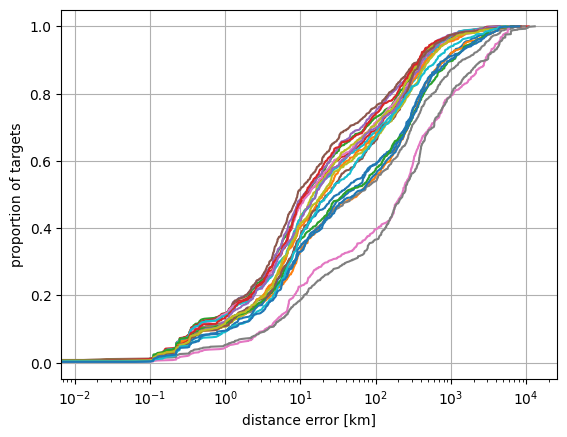

In [6]:
fig, ax1 = plt.subplots(1, 1)

answer_granularity = "answer_bgp_prefix"
per_cdn_results = load_pickle(
    path_settings.RESULTS_PATH / "results_1M_hostnames_answer_bgp_prefix_per_cdn.pickle"
)

for cdn, cdn_results in per_cdn_results.items():
    for budget, target_results in cdn_results.items():
        if budget in [50]:

            x, y = ecdf([e["elected_d_error"] for e in target_results.values()])
            ax1.plot(x, y, label=f"{cdn}, ECS-DNS, Subnet, {budget} VPs")
            mean_error = np.median(
                [l["elected_d_error"] for l in target_results.values()]
            )

            logger.info(
                f"{cdn}, probing budget = {budget}, geolocated ip addr = {len(target_results.values())}, median error = {round(mean_error, 2)} [km]"
            )
plt.xlabel("distance error [km]")
plt.ylabel("proportion of targets")
# plt.legend(loc="lower right", fontsize=10)
plt.xscale("log")
plt.grid()
plt.savefig(path_settings.FIGURE_PATH / "geolocation_error_ecs_dns_subnets.pdf")
plt.show()

# Greedy BGP prefix

In [7]:
answer_granularity = "answer_bgp_prefix"
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / f"results_1M_hostnames_answer_bgp_prefix_greedy_bgp.pickle"
)

2024-03-20 16:52:17.769 | INFO     | __main__:<module>:9 - Shortest Ping ref, median_error=7.08 [km], 729 IP addresses 
2024-03-20 16:52:17.772 | INFO     | __main__:<module>:19 - Max score VP, answer_bgp_prefix, median_error=75.67 [km], 729 IP addresses
2024-03-20 16:52:17.776 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=5, answer_granularity='answer_bgp_prefix', median_error=22.72 [km], 697 IP addresses
2024-03-20 16:52:17.778 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=10, answer_granularity='answer_bgp_prefix', median_error=17.39 [km], 718 IP addresses
2024-03-20 16:52:17.780 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median_error=9.56 [km], 729 IP addresses


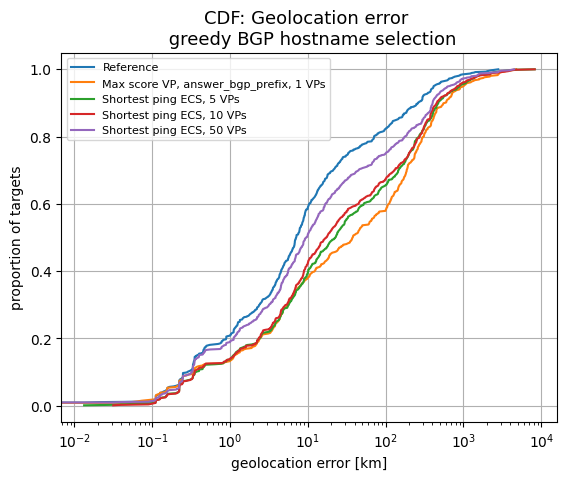

In [8]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([e["ref_d_error"] for e in results[50].values()])
ax1.plot(x, y, label=f"Reference")

ref_median = round(np.median([d["ref_d_error"] for d in results[50].values()]), 2)
logger.info(
    f"Shortest Ping ref, median_error={ref_median} [km], {len(results[50].values())} IP addresses "
)

x, y = ecdf([e["max_score_d_error"] for e in results[1].values()])
ax1.plot(x, y, label=f"Max score VP, {answer_granularity}, 1 VPs")

max_score_median = round(
    np.median([d["max_score_d_error"] for d in results[50].values()]), 2
)
logger.info(
    f"Max score VP, {answer_granularity}, median_error={max_score_median} [km], {len(results[50].values())} IP addresses"
)


# # plot results for reference vp selection
for budget in results:

    if budget in [5, 10, 50]:
        x, y = ecdf([e["elected_d_error"] for e in results[budget].values()])
        ax1.plot(x, y, label=f"Shortest ping ECS, {budget} VPs")

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median_error={round(np.median([d['elected_d_error'] for d in results[budget].values()]), 2)} [km], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n greedy BGP hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_greedy_bgp.pdf")
plt.show()

2024-03-20 16:52:18.433 | INFO     | __main__:<module>:9 - Shortest Ping ref, median_error=0.79 [ms], 729 IP addresses 
2024-03-20 16:52:18.436 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=5, answer_granularity='answer_bgp_prefix', median latency=2.54 [ms], 697 IP addresses
2024-03-20 16:52:18.439 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=10, answer_granularity='answer_bgp_prefix', median latency=1.92 [ms], 718 IP addresses
2024-03-20 16:52:18.441 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median latency=1.11 [ms], 729 IP addresses


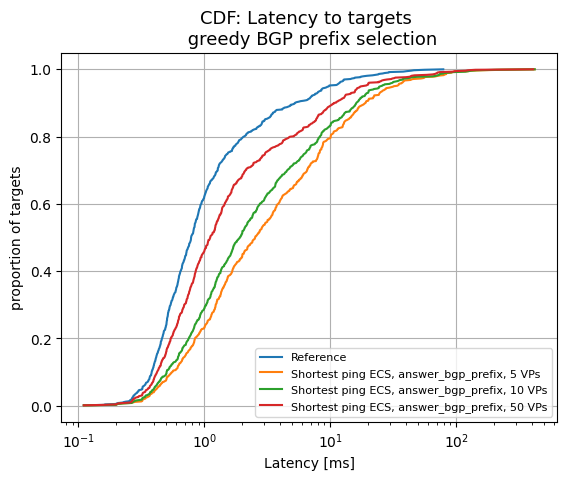

In [9]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([e["ref_min_rtt"] for e in results[50].values()])
ax1.plot(x, y, label=f"Reference")

ref_median = round(np.median([d["ref_min_rtt"] for d in results[50].values()]), 2)
logger.info(
    f"Shortest Ping ref, median_error={ref_median} [ms], {len(results[50].values())} IP addresses "
)

# x, y = ecdf([e["max_score_d_error"] for e in results[1].values()])
# ax1.plot(x, y, label=f"Max score VP, {answer_granularity}, 1 VPs")

# max_score_median = round(
#     np.median([d["max_score_d_error"] for d in results[50].values()]), 2
# )
# logger.info(
#     f"Max score VP, {answer_granularity}, median_error={max_score_median} [km], {len(results[50].values())} IP addresses"
# )


# # plot results for reference vp selection
for budget in results:

    if budget in [5, 10, 50]:
        x, y = ecdf([e["elected_rtt"] for e in results[budget].values()])
        ax1.plot(x, y, label=f"Shortest ping ECS, {answer_granularity}, {budget} VPs")

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median latency={round(np.median([d['elected_rtt'] for d in results[budget].values()]), 2)} [ms], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("Latency [ms]")
plt.ylabel("proportion of targets")
plt.legend(loc="lower right", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Latency to targets \n greedy BGP prefix selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "latencies_greedy_bgp.pdf")
plt.show()

# Greedy CDN

In [10]:
answer_granularity = "answer_bgp_prefix"
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / f"results_1M_hostnames_answer_bgp_prefix_greedy_cdn.pickle"
)

2024-03-20 16:52:19.056 | INFO     | __main__:<module>:9 - Shortest Ping ref, median_error=7.03 [km], 725 IP addresses 
2024-03-20 16:52:19.059 | INFO     | __main__:<module>:19 - Max score VP, answer_bgp_prefix, median_error=81.83 [km], 725 IP addresses
2024-03-20 16:52:19.062 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=5, answer_granularity='answer_bgp_prefix', median_error=24.47 [km], 694 IP addresses
2024-03-20 16:52:19.065 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=10, answer_granularity='answer_bgp_prefix', median_error=18.99 [km], 719 IP addresses
2024-03-20 16:52:19.067 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median_error=9.88 [km], 725 IP addresses


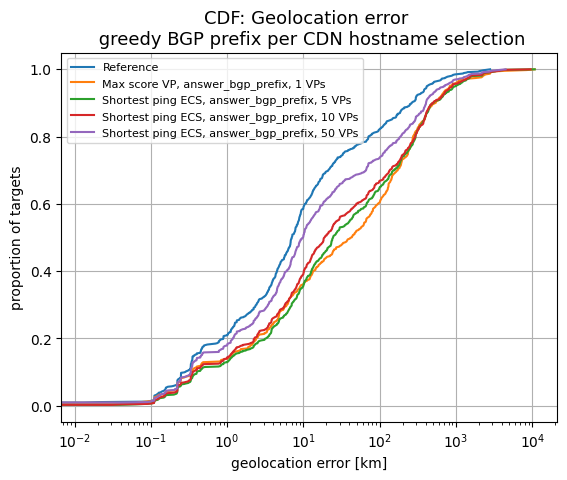

In [11]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([e["ref_d_error"] for e in results[50].values()])
ax1.plot(x, y, label=f"Reference")

ref_median = round(np.median([d["ref_d_error"] for d in results[50].values()]), 2)
logger.info(
    f"Shortest Ping ref, median_error={ref_median} [km], {len(results[50].values())} IP addresses "
)

x, y = ecdf([e["max_score_d_error"] for e in results[1].values()])
ax1.plot(x, y, label=f"Max score VP, {answer_granularity}, 1 VPs")

max_score_median = round(
    np.median([d["max_score_d_error"] for d in results[50].values()]), 2
)
logger.info(
    f"Max score VP, {answer_granularity}, median_error={max_score_median} [km], {len(results[50].values())} IP addresses"
)


# # plot results for reference vp selection
for budget in results:

    if budget in [5, 10, 50]:
        x, y = ecdf([e["elected_d_error"] for e in results[budget].values()])
        ax1.plot(x, y, label=f"Shortest ping ECS, {answer_granularity}, {budget} VPs")

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median_error={round(np.median([d['elected_d_error'] for d in results[budget].values()]), 2)} [km], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n greedy BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_greedy_cdn.pdf")
plt.show()

2024-03-20 16:52:19.833 | INFO     | __main__:<module>:9 - Shortest Ping ref, median_error=7.03 [km], 725 IP addresses 
2024-03-20 16:52:19.836 | INFO     | __main__:<module>:20 - Shortest ping ECS, budget=5, answer_granularity='answer_bgp_prefix', median latency=2.86 [ms], 694 IP addresses
2024-03-20 16:52:19.839 | INFO     | __main__:<module>:20 - Shortest ping ECS, budget=10, answer_granularity='answer_bgp_prefix', median latency=2.01 [ms], 719 IP addresses
2024-03-20 16:52:19.841 | INFO     | __main__:<module>:20 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median latency=1.2 [ms], 725 IP addresses


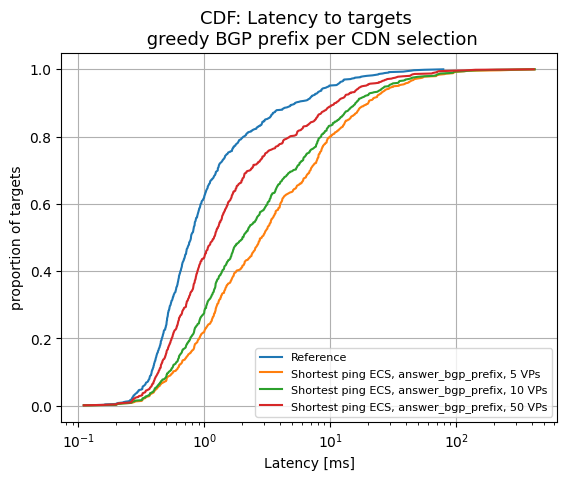

In [12]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([e["ref_min_rtt"] for e in results[50].values()])
ax1.plot(x, y, label=f"Reference")

ref_median = round(np.median([d["ref_d_error"] for d in results[50].values()]), 2)
logger.info(
    f"Shortest Ping ref, median_error={ref_median} [km], {len(results[50].values())} IP addresses "
)

# # plot results for reference vp selection
for budget in results:

    if budget in [5, 10, 50]:
        x, y = ecdf([e["elected_rtt"] for e in results[budget].values()])
        ax1.plot(x, y, label=f"Shortest ping ECS, {answer_granularity}, {budget} VPs")

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median latency={round(np.median([d['elected_rtt'] for d in results[budget].values()]), 2)} [ms], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("Latency [ms]")
plt.ylabel("proportion of targets")
plt.legend(loc="lower right", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Latency to targets \n greedy BGP prefix per CDN selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "latencies_greedy_cdn.pdf")
plt.show()

# Max BGP prefix

In [13]:
answer_granularity = "answer_bgp_prefix"
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / f"results_1M_hostnames_answer_bgp_prefix_max_bgp_prefix.pickle"
)

2024-03-20 16:52:20.415 | INFO     | __main__:<module>:9 - Shortest Ping ref, median_error=7.11 [km], 740 IP addresses 
2024-03-20 16:52:20.420 | INFO     | __main__:<module>:19 - Max score VP, answer_bgp_prefix, median_error=45.33 [km], 740 IP addresses
2024-03-20 16:52:20.423 | INFO     | __main__:<module>:31 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median_error=8.06 [km], 740 IP addresses


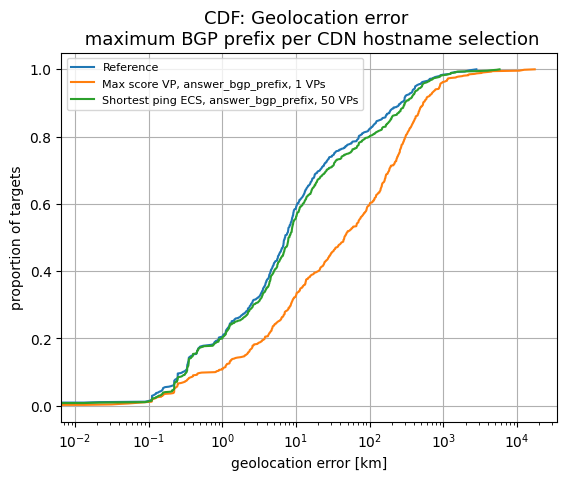

In [14]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([e["ref_d_error"] for e in results[50].values()])
ax1.plot(x, y, label=f"Reference")

ref_median = round(np.median([d["ref_d_error"] for d in results[50].values()]), 2)
logger.info(
    f"Shortest Ping ref, median_error={ref_median} [km], {len(results[50].values())} IP addresses "
)

x, y = ecdf([e["max_score_d_error"] for e in results[50].values()])
ax1.plot(x, y, label=f"Max score VP, {answer_granularity}, 1 VPs")

max_score_median = round(
    np.median([d["max_score_d_error"] for d in results[50].values()]), 2
)
logger.info(
    f"Max score VP, {answer_granularity}, median_error={max_score_median} [km], {len(results[50].values())} IP addresses"
)


# # plot results for reference vp selection
for budget in results:

    if budget in [5, 10, 50]:
        x, y = ecdf([e["elected_d_error"] for e in results[budget].values()])
        ax1.plot(x, y, label=f"Shortest ping ECS, {answer_granularity}, {budget} VPs")

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median_error={round(np.median([d['elected_d_error'] for d in results[budget].values()]), 2)} [km], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n maximum BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_max_bgp_prefix.pdf")
plt.show()

2024-03-20 16:52:21.031 | INFO     | __main__:<module>:9 - Shortest Ping ref, median latency=0.79 [ms], 740 IP addresses 
2024-03-20 16:52:21.035 | INFO     | __main__:<module>:20 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median latency=0.99 [ms], 740 IP addresses


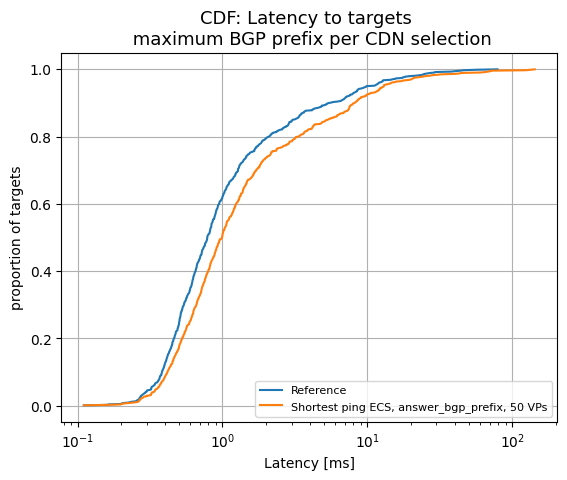

In [15]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([e["ref_min_rtt"] for e in results[50].values()])
ax1.plot(x, y, label=f"Reference")

ref_median = round(np.median([d["ref_min_rtt"] for d in results[50].values()]), 2)
logger.info(
    f"Shortest Ping ref, median latency={ref_median} [ms], {len(results[50].values())} IP addresses "
)

# # plot results for reference vp selection
for budget in results:

    if budget in [5, 10, 50]:
        x, y = ecdf([e["elected_rtt"] for e in results[budget].values()])
        ax1.plot(x, y, label=f"Shortest ping ECS, {answer_granularity}, {budget} VPs")

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median latency={round(np.median([d['elected_rtt'] for d in results[budget].values()]), 2)} [ms], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("Latency [ms]")
plt.ylabel("proportion of targets")
plt.legend(loc="lower right", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Latency to targets \n maximum BGP prefix per CDN selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "latencies_max_prefix_bgp.pdf")
plt.show()

2024-03-20 16:52:21.530 | INFO     | __main__:<module>:17 - budget = 50, median dif = 0.03 [ms]


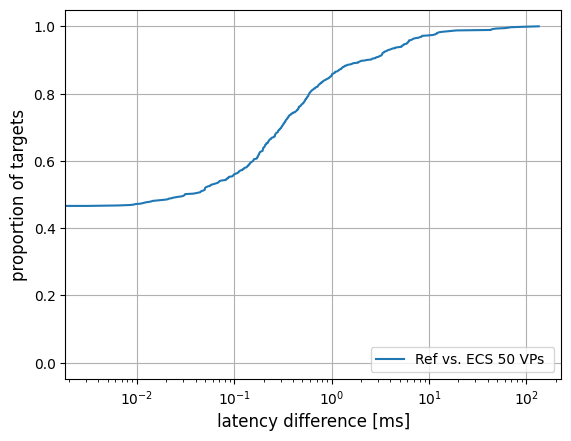

In [16]:
fig, ax1 = plt.subplots(1, 1)

# # plot results for reference vp selection
for budget, target_results in results.items():
    if budget in [5, 10, 50, 100, 200, 500]:
        latency_diff = {}
        for target, result in target_results.items():
            ecs_latency = result["elected_rtt"]
            ref_latency = ref_latency_target[target]

            latency_diff[target] = ecs_latency - ref_latency

        x, y = ecdf([diff for diff in latency_diff.values()])
        median_diff = np.median([diff for diff in latency_diff.values()])

        ax1.plot(x, y, label=f"Ref vs. ECS {budget} VPs ")
        logger.info(f"budget = {budget}, median dif = {round(median_diff, 2)} [ms]")

plt.xlabel("latency difference [ms]", fontsize=12)
plt.ylabel("proportion of targets", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.xscale("log")
plt.grid()
plt.savefig(path_settings.FIGURE_PATH / "latency_ecs_dns.pdf")
plt.show()

2024-03-20 16:52:22.425 | INFO     | __main__:<module>:20 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median_error=45.33 [km], 740 IP addresses


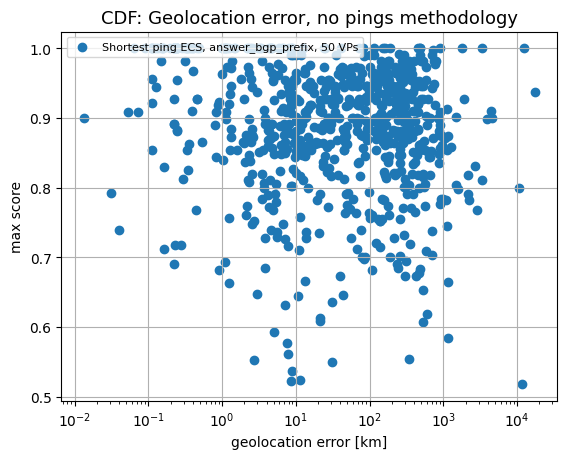

In [17]:
answer_granularity = "answer_bgp_prefix"
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / f"results_1M_hostnames_answer_bgp_prefix_max_bgp_prefix.pickle"
)

results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

# # plot results for reference vp selection
for budget, target_results in results.items():

    if budget in [50]:
        x, y = [], []
        for target, result in target_results.items():

            x.append(result["max_score_d_error"])
            # y.append(np.mean([v[-1] for v in result["first_elected_vps_scores"][:10]]))
            y.append(result["max_score"])

        ax1.scatter(
            x, y, label=f"Shortest ping ECS, {answer_granularity}, {budget} VPs"
        )

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median_error={round(np.median([d['max_score_d_error'] for d in results[budget].values()]), 2)} [km], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("geolocation error [km]")
plt.ylabel("max score")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error, no pings methodology",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "no_pings.pdf")
plt.show()

# Cluster Max Score VP

In [18]:
answer_granularity = "answer_bgp_prefix"
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / f"results_1M_hostnames_answer_bgp_prefix_max_bgp_prefix.pickle"
)

2024-03-20 16:52:23.132 | INFO     | __main__:<module>:9 - Shortest Ping ref, median_error=7.11 [km], 740 IP addresses 
2024-03-20 16:52:23.135 | INFO     | __main__:<module>:19 - Cluster Max score VP, answer_bgp_prefix, median_error=45.33 [km], 740 IP addresses
2024-03-20 16:52:23.138 | INFO     | __main__:<module>:32 - Cluster Max score VP, answer_bgp_prefix, median_error=19.94 [km], 740 IP addresses
2024-03-20 16:52:23.140 | INFO     | __main__:<module>:47 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median_error=8.06 [km], 740 IP addresses


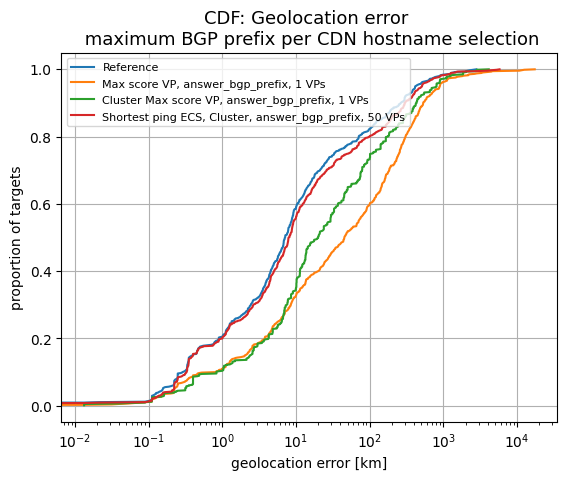

In [19]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([e["ref_d_error"] for e in results[50].values()])
ax1.plot(x, y, label=f"Reference")

ref_median = round(np.median([d["ref_d_error"] for d in results[50].values()]), 2)
logger.info(
    f"Shortest Ping ref, median_error={ref_median} [km], {len(results[50].values())} IP addresses "
)

x, y = ecdf([e["max_score_d_error"] for e in results[50].values()])
ax1.plot(x, y, label=f"Max score VP, {answer_granularity}, 1 VPs")

max_score_median = round(
    np.median([d["max_score_d_error"] for d in results[50].values()]), 2
)
logger.info(
    f"Cluster Max score VP, {answer_granularity}, median_error={max_score_median} [km], {len(results[50].values())} IP addresses"
)

cluster_max_score_errors = [
    e["cluster_max_score_d_error"] for e in results[50].values()
]
x, y = ecdf(cluster_max_score_errors)
ax1.plot(x, y, label=f"Cluster Max score VP, {answer_granularity}, 1 VPs")

max_score_median = round(
    np.median([d["cluster_max_score_d_error"] for d in results[50].values()]), 2
)
logger.info(
    f"Cluster Max score VP, {answer_granularity}, median_error={max_score_median} [km], {len(cluster_max_score_errors)} IP addresses"
)

# # plot results for reference vp selection
for budget in results:

    if budget in [50]:
        x, y = ecdf([e["elected_d_error"] for e in results[budget].values()])
        ax1.plot(
            x,
            y,
            label=f"Shortest ping ECS, Cluster, {answer_granularity}, {budget} VPs",
        )

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median_error={round(np.median([d['elected_d_error'] for d in results[budget].values()]), 2)} [km], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n maximum BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_max_bgp_prefix.pdf")
plt.show()

In [20]:
# # plot results for reference vp selection
for budget in results:

    if budget in [50]:

        mean_vp_selected = np.mean(
            [
                len(target_results["cluster_vps"])
                for target_results in results[50].values()
            ]
        )

        median_vp_selected = np.median(
            [
                len(target_results["cluster_vps"])
                for target_results in results[50].values()
            ]
        )

        logger.info(
            f"Shortest ping ECS, {answer_granularity=}, {mean_vp_selected=}, {median_vp_selected=}"
        )

2024-03-20 16:52:23.739 | INFO     | __main__:<module>:20 - Shortest ping ECS, answer_granularity='answer_bgp_prefix', mean_vp_selected=0.0, median_vp_selected=0.0


2024-03-20 16:52:23.782 | INFO     | __main__:<module>:20 - Shortest ping ECS, budget=50, answer_granularity='answer_bgp_prefix', median_error=45.33 [km], 740 IP addresses


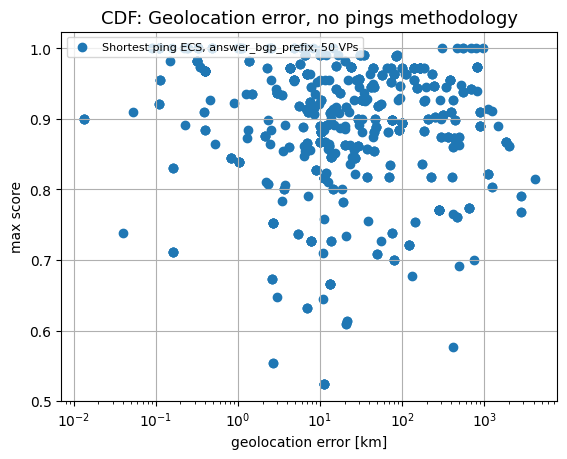

In [21]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

# # plot results for reference vp selection
for budget, target_results in results.items():

    if budget in [50]:
        x, y = [], []
        for target, result in target_results.items():

            x.append(result["cluster_max_score_d_error"])
            # y.append(np.mean([v[-1] for v in result["first_elected_vps_scores"][:10]]))
            y.append(result["cluster_max_score"])

        ax1.scatter(
            x, y, label=f"Shortest ping ECS, {answer_granularity}, {budget} VPs"
        )

        logger.info(
            f"Shortest ping ECS, {budget=}, {answer_granularity=}, median_error={round(np.median([d['max_score_d_error'] for d in results[budget].values()]), 2)} [km], {len(results[budget].values())} IP addresses"
        )

plt.xlabel("geolocation error [km]")
plt.ylabel("max score")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error, no pings methodology",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "no_pings.pdf")
plt.show()